## Agrupación de IPs por sus palabras clave

Paso 1: Cargar el dataset

In [2]:
import pandas as pd

df = pd.read_csv("Keywords/author_keyword_matrix.csv", index_col=0)

# Mostrar resumen
print("✅ Dataset generado con forma:", df.shape)
print("🔢 Palabras clave totales:", len(df.columns))
print("👥 Autores con keywords:", len(df))

✅ Dataset generado con forma: (29, 3329)
🔢 Palabras clave totales: 3329
👥 Autores con keywords: 29


Paso 2: Preprocesamiento (normalización y reducción PCA)

In [3]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

X = df.values
X_normalized = Normalizer().fit_transform(X)

Paso 3: Clustering con KMeans

In [6]:
# === Configuraciones de preprocesamiento y clustering ===
pca_dims = [2, 5, 10, 20]
k_values = list(range(2, 16))

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Evaluar KMeans para k entre 2 y 15
results = []

for n_dim in pca_dims:
    X_reduced = PCA(n_components=n_dim).fit_transform(X_normalized)

    for k in k_values:
        try:
            model = KMeans(n_clusters=k, random_state=42)
            labels = model.fit_predict(X_reduced)

            silhouette = silhouette_score(X_reduced, labels)
            ch_score = calinski_harabasz_score(X_reduced, labels)
            db_score = davies_bouldin_score(X_reduced, labels)

            results.append({
                "PCA_dims": n_dim,
                "k": k,
                "Silhouette": silhouette,
                "Calinski-Harabasz": ch_score,
                "Davies-Bouldin": db_score,
                "Labels": labels
            })

        except Exception as e:
            results.append({
                "PCA_dims": n_dim,
                "k": k,
                "Silhouette": np.nan,
                "Calinski-Harabasz": np.nan,
                "Davies-Bouldin": np.nan,
                "Error": str(e),
                "Labels": []
            })

# === Convertir a DataFrame
df_results = pd.DataFrame(results).dropna(subset=["Silhouette"])
print("✅ Resultados de clustering generados con forma:", df_results.shape)
print("🔍 Resultados de clustering:", df_results.head())

✅ Resultados de clustering generados con forma: (56, 6)
🔍 Resultados de clustering:    PCA_dims  k  Silhouette  Calinski-Harabasz  Davies-Bouldin  \
0         2  2    0.340874          13.683798        1.055788   
1         2  3    0.579625          48.123236        0.584587   
2         2  4    0.536744          46.455511        0.580609   
3         2  5    0.549741          53.009822        0.647539   
4         2  6    0.611173          62.740611        0.481136   

                                              Labels  
0  [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...  
1  [2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 0, 1, 1, 0, 0, ...  
2  [3, 0, 0, 2, 2, 3, 3, 1, 2, 2, 0, 1, 1, 0, 0, ...  
3  [3, 0, 0, 2, 2, 0, 3, 1, 2, 2, 0, 1, 1, 4, 4, ...  
4  [3, 5, 5, 2, 2, 0, 3, 1, 2, 2, 0, 1, 1, 4, 4, ...  


In [11]:
# === Guardar top 3 por Silhouette con distinto número de clusters
df_results_unique_k = df_results.sort_values("Silhouette", ascending=False)
top_configs = df_results_unique_k.drop_duplicates(subset=["k"]).head(3)

# === Visualización de resultados agregados por PCA_dims
melted = df_results.melt(id_vars=["PCA_dims", "k"], value_vars=["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"],
                         var_name="Métrica", value_name="Valor")

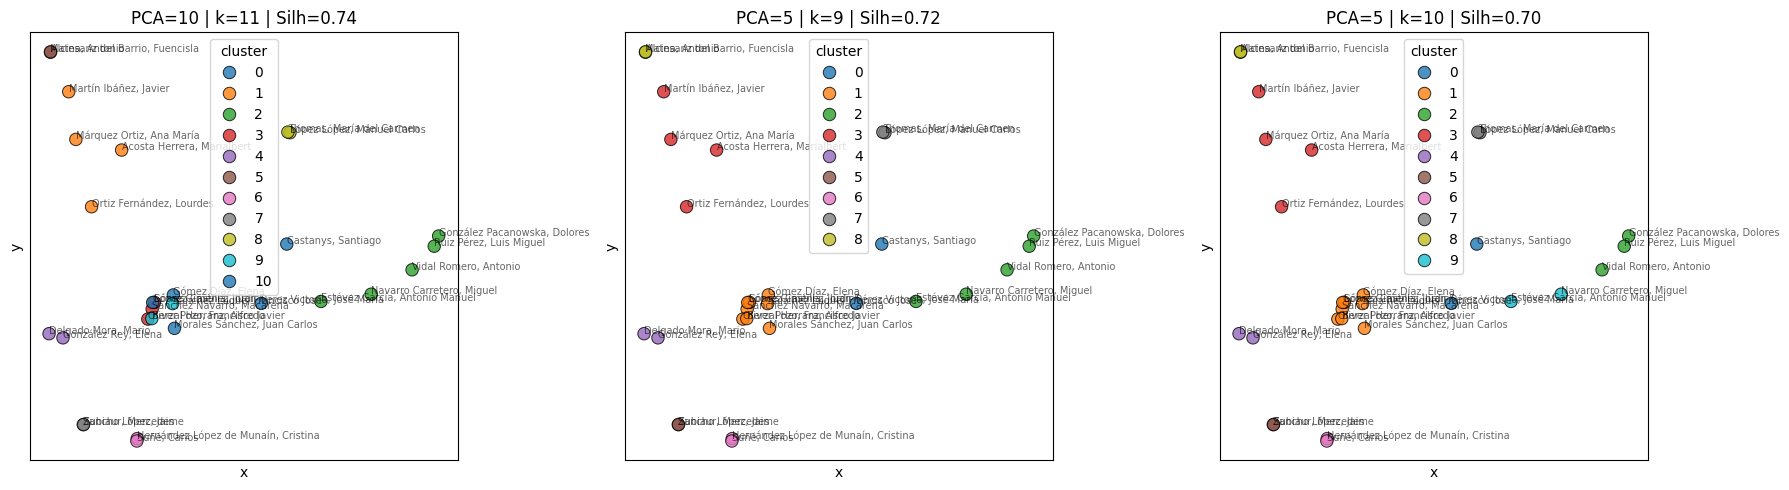

In [12]:
# === Visualización de los 3 mejores clustering en 2D
from sklearn.decomposition import PCA

X_2d = PCA(n_components=2).fit_transform(X_normalized)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=100)

for ax, (_, row) in zip(axes, top_configs.iterrows()):
    labels = row["Labels"]
    coords_df = pd.DataFrame(X_2d, columns=["x", "y"])
    coords_df["author"] = df.index
    coords_df["cluster"] = labels

    sns.scatterplot(data=coords_df, x="x", y="y", hue="cluster", palette="tab10", ax=ax, s=80, edgecolor='k', alpha=0.8)
    for _, r in coords_df.iterrows():
        ax.text(r["x"], r["y"], r["author"], fontsize=7, alpha=0.6)
    
    ax.set_title(f"PCA={row['PCA_dims']} | k={row['k']} | Silh={row['Silhouette']:.2f}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

Seleccionamos la mejor combinación por número de clusters

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Copia de las métricas para trabajar sobre ellas
metrics = df_results[["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]].copy()

# Invertimos Davies-Bouldin porque más bajo = mejor
metrics["Davies-Bouldin"] = -metrics["Davies-Bouldin"]

# Normalizar todas las métricas entre 0 y 1
scaled = pd.DataFrame(MinMaxScaler().fit_transform(metrics), columns=metrics.columns)

# Calcular score combinado (puedes ajustar los pesos según preferencia)
df_results["score_combined"] = (
    0.8 * scaled["Silhouette"] +
    0.1 * scaled["Calinski-Harabasz"] +
    0.1 * scaled["Davies-Bouldin"]
)

# Seleccionar la mejor configuración para cada valor único de k
best_per_k = (
    df_results
    .sort_values("score_combined", ascending=False)
    .drop_duplicates(subset=["k"])
    .sort_values("k")
)

# Mostrar resumen
print("✅ Mejores configuraciones por número de clusters:")
print(best_per_k[["PCA_dims", "k", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin", "score_combined"]])


✅ Mejores configuraciones por número de clusters:
    PCA_dims   k  Silhouette  Calinski-Harabasz  Davies-Bouldin  \
0          2   2    0.340874          13.683798        1.055788   
1          2   3    0.579625          48.123236        0.584587   
2          2   4    0.536744          46.455511        0.580609   
3          2   5    0.549741          53.009822        0.647539   
4          2   6    0.611173          62.740611        0.481136   
5          2   7    0.674780          73.790982        0.381399   
6          2   8    0.674055         114.925360        0.419254   
21         5   9    0.724193          88.430330        0.350451   
22         5  10    0.703418         103.979623        0.365198   
9          2  11    0.676381         146.438714        0.321635   
10         2  12    0.646028         171.177809        0.309201   
11         2  13    0.630159         183.567273        0.284132   
12         2  14    0.601865         214.380623        0.211207   
13         2

Visualizamos las configuraciones

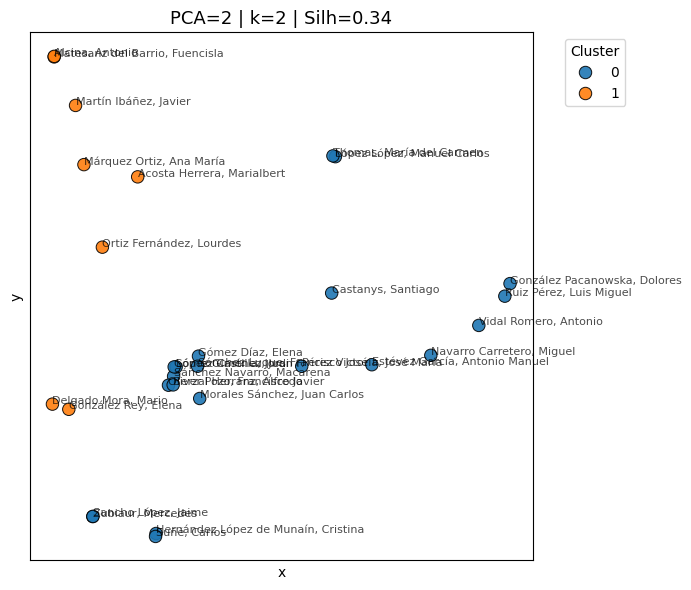

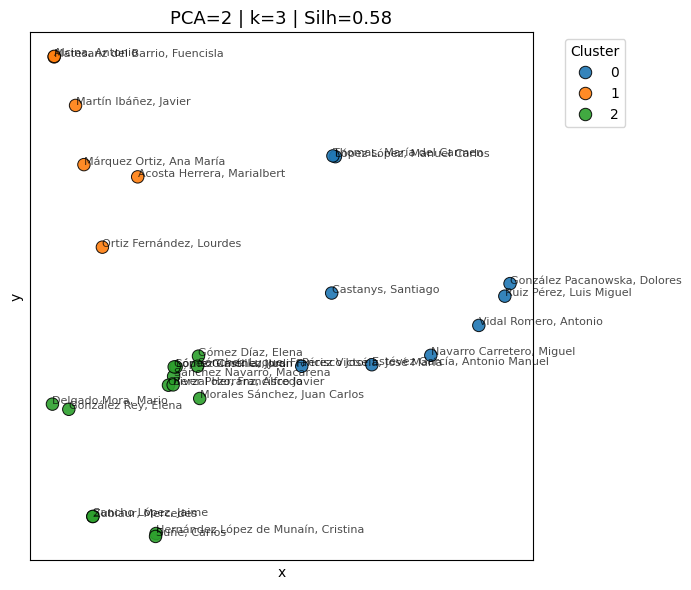

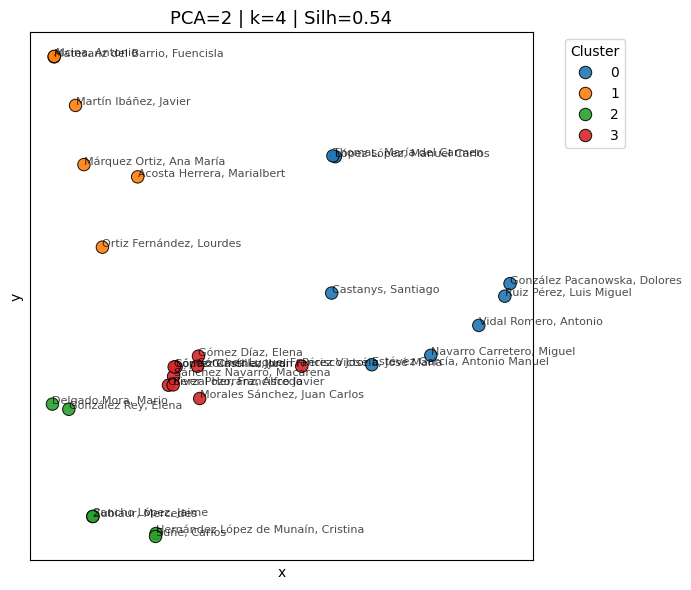

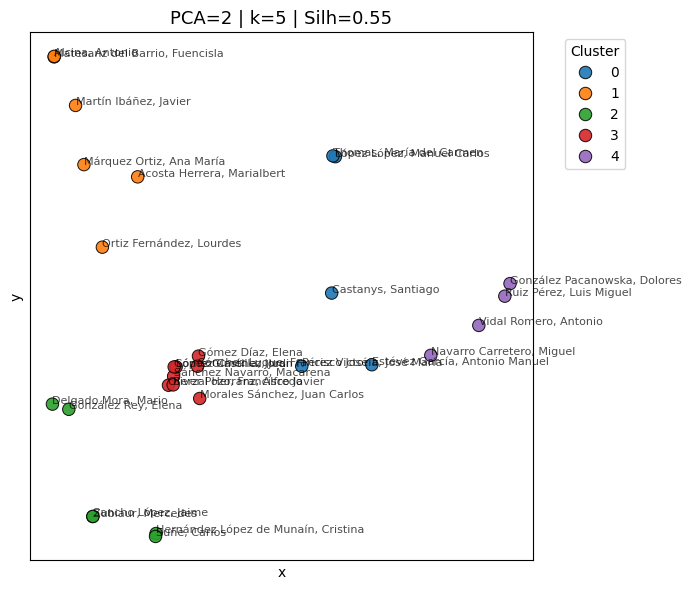

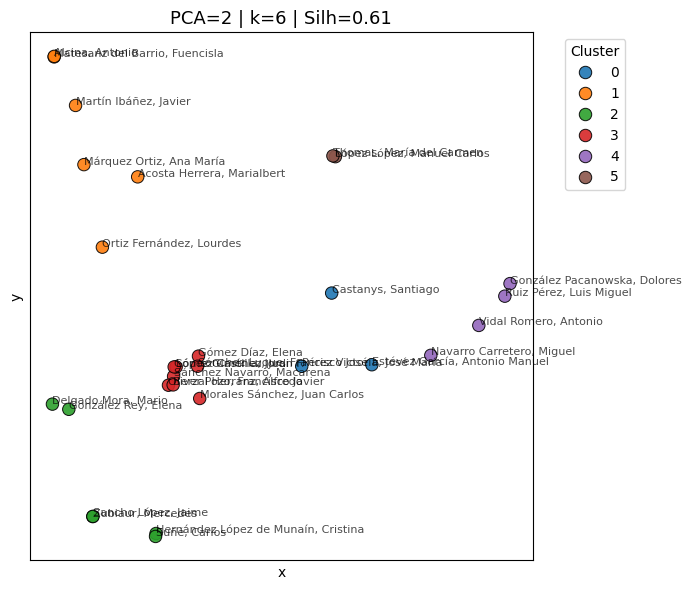

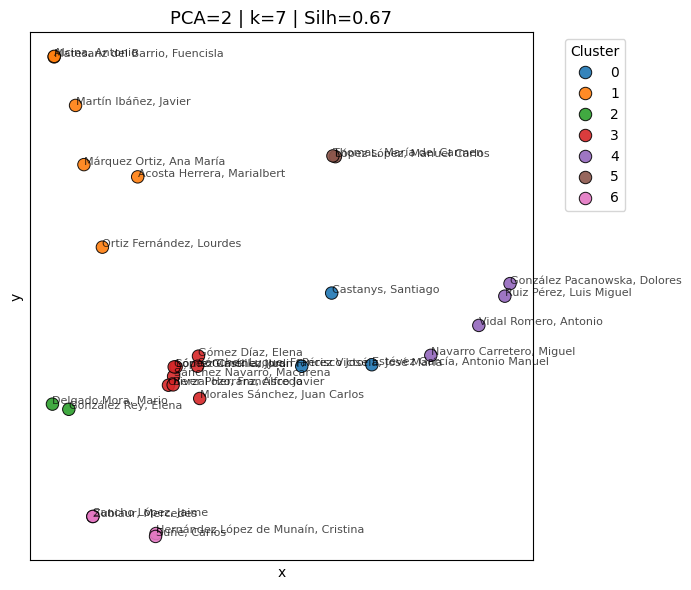

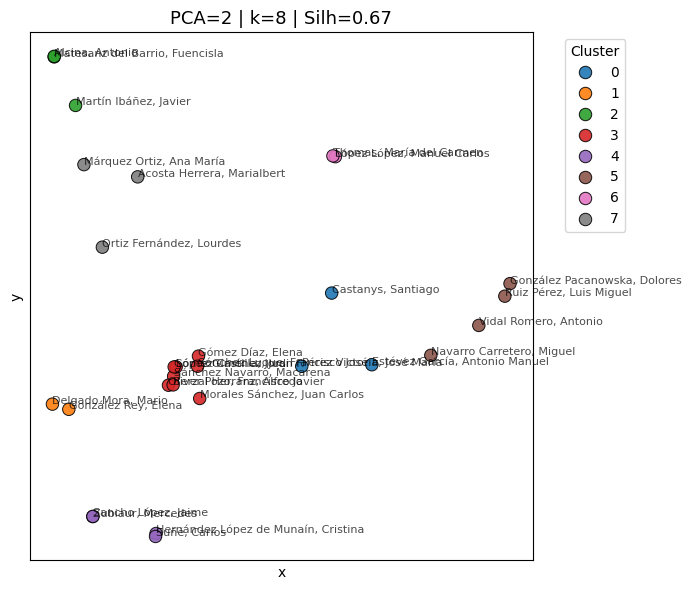

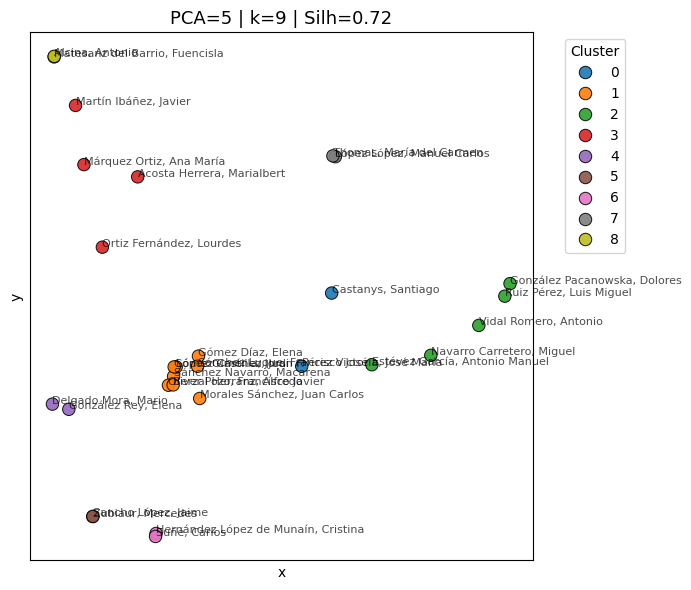

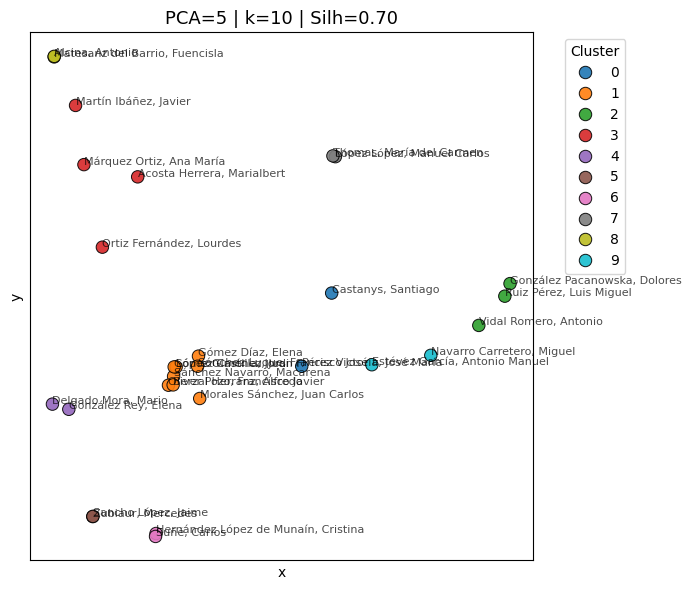

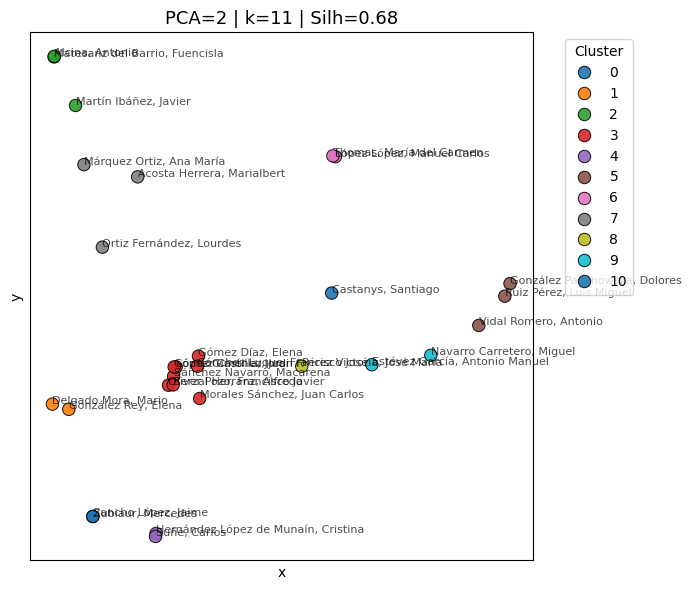

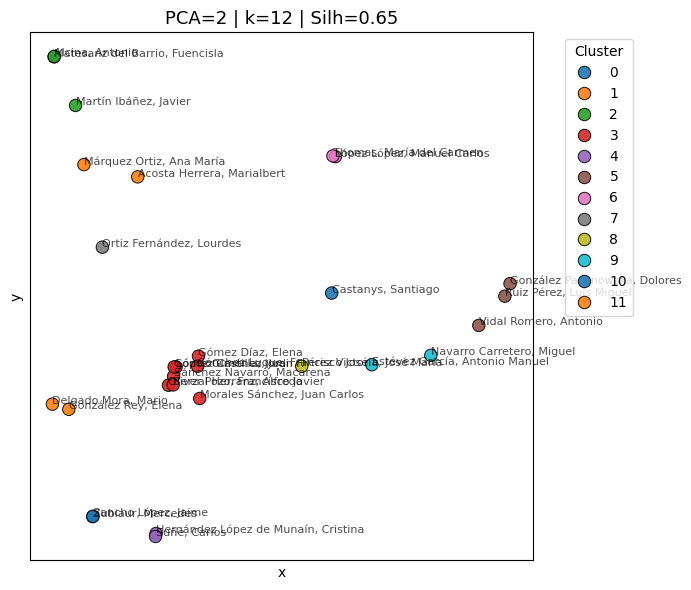

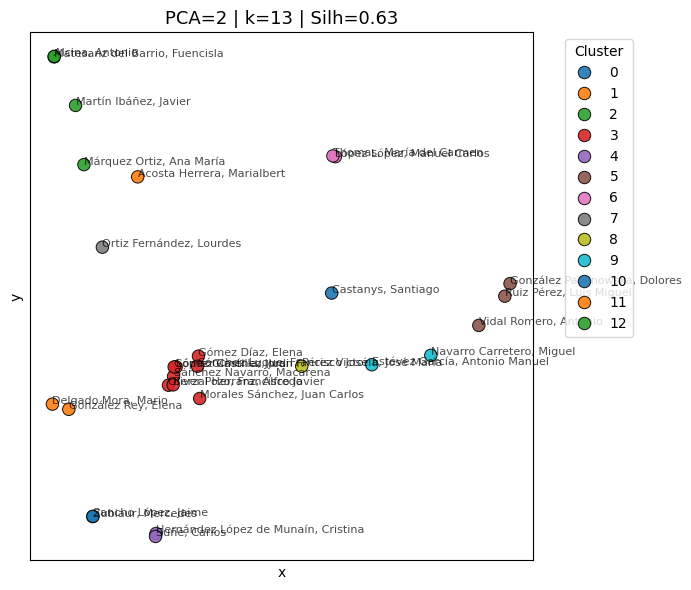

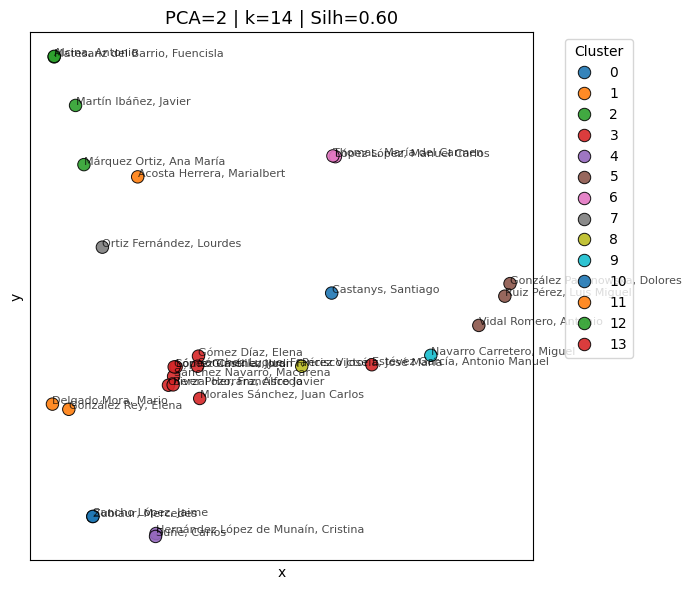

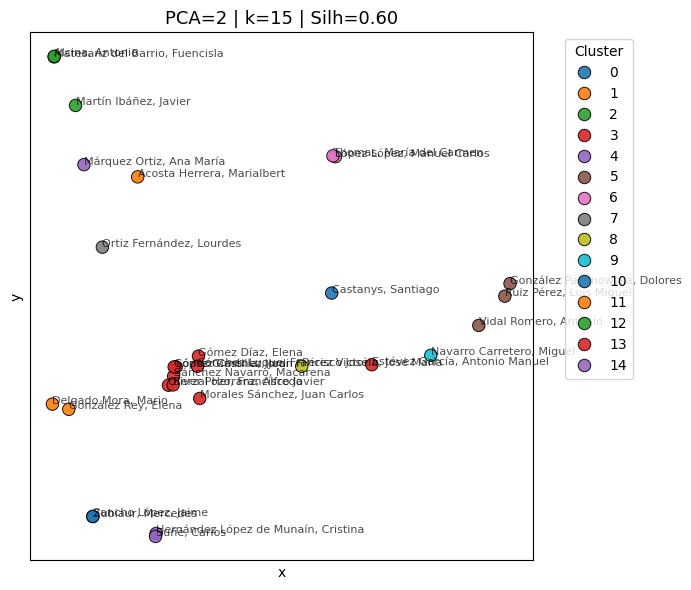

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Reducimos los datos a 2D una sola vez para visualización
X_2d = PCA(n_components=2).fit_transform(X_normalized)

# Iterar por cada configuración óptima
for _, row in best_per_k.iterrows():
    labels = row["Labels"]
    coords_df = pd.DataFrame(X_2d, columns=["x", "y"])
    coords_df["author"] = df.index
    coords_df["cluster"] = labels

    plt.figure(figsize=(7, 6), dpi=100)
    sns.scatterplot(
        data=coords_df,
        x="x", y="y",
        hue="cluster",
        palette="tab10",
        s=80,
        edgecolor='k',
        alpha=0.9
    )

    for _, r in coords_df.iterrows():
        plt.text(r["x"], r["y"], r["author"], fontsize=8, alpha=0.7)

    plt.title(f"PCA={row['PCA_dims']} | k={row['k']} | Silh={row['Silhouette']:.2f}", fontsize=13)
    plt.xticks([])
    plt.yticks([])
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Guardamos los resultados

In [ ]:
cluster_records = []

for _, row in best_per_k.iterrows():
    labels = row["Labels"]
    k = row["k"]
    pca_dims = row["PCA_dims"]
    silhouette = row["Silhouette"]
    ch_score = row["Calinski-Harabasz"]
    db_score = row["Davies-Bouldin"]

    for author, cluster in zip(df.index, labels):
        cluster_records.append({
            "author": author,
            "cluster": int(cluster),
            "k": k,
            "pca_dims": pca_dims,
            "silhouette": silhouette,
            "calinski_harabasz": ch_score,
            "davies_bouldin": db_score
        })

df_clusters_export = pd.DataFrame(cluster_records)
df_clusters_export.to_csv("Keywords/KMeans/kmeans_best_configs.csv", index=False)

print("✅ Resultados guardados en formato CSV para importación en base de datos.")

✅ Resultados guardados en formato CSV para importación en base de datos.
